## Introduction

For my detector, I wanted to try build something akin to the inner layers of the Atlas experiment, at least an extremely simple version thats basically just got the same inner layers. I have two silicon tracking layers. These will help me identify particles based on how they move within the magnetic field of 0.5 $\hat x$. I then have two calorimeter detector blocks. The first is a slightly alterered version of EM calorimeter we used in Example 2, made from liquid argon and lead layers. At the start just it's size is changed, but I had to alter a lot of the code in order to also read out the hadronic calorimeter data. I researched the Atlas detector a bit, and seen that the following Hadronic calorimeter after the EM calorimeter was made from steel and plastic layers. I then built this through altering the example 2 code, both for the construction and reading the data to a file. 

I wrote all of the layer (and truth) data to the same file, and used splicing to seperate the layers to their respective calorimeter. 

I initially started this detector such that the particle gun will randomly shoot an e- or an e+, with me then using python code to use the tracking data from the silicon detector to classify each of them. This was quite a simple classification task. I hoped to be able to extrapolate this such that I can identify other particles using perhaps more rigourous methods. A challenge that was posed by this, is that I often would get multiple hits on each detector on the same event, so I had to add code to filter the extra points.



In [1]:
#Imports
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

## Section 1: Geant4 Simulation

I have already described the structure of my simulation above. I had two calorimeters and a silicon tracking structure. The first calorimeter was effectively the same as example 2, but for the second I changed materials and number of layers. I also had to edit a lot of the for loop and write out methods used in example 2 in order to not only make each layer a detector but to also ensure no overlap or overwriting data. The silicon layers I made by just adding very thin discs of silicon for the particles to pass for.


See below a screenshot of the setup

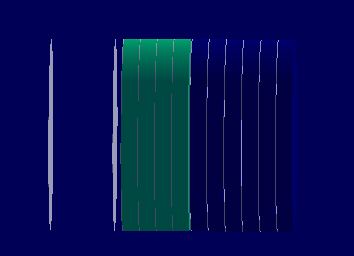

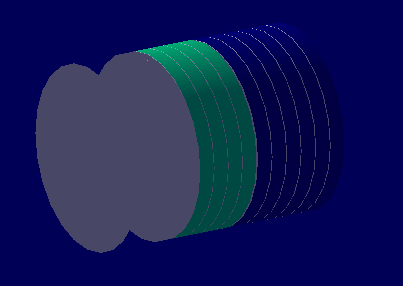

Two grey layers - Silicon Trackers <br>
Green layers - Electromagnetic Calorimeter, made from Liquid Argon detectors and lead absorbers(4 Layers) <br>
Blue layers - Hadronic Calorimeter, made from stainless steel absorbers and plastic detectors( 6layers)
particle gun - Randomly shot different particles chosen from random number generation, 0.5T magnetic field in x direction

## Section 2: Data Reconstruction


#### Energy Scales
Similar to Example2, I coded up an algorithm to add 200 MeV to the particle energy at the end of each simulation. I then ran the code a few thousand times. The starting energy was of order 1GeV, and went to order 400GeV. (As a side note I do alter this range a lot to provide quick tests for certain things, it is possible my raw c++ code doesn't exactly have the 1GeV - 400GeV range, but it would be very easily seen how it is done as I merely just add a value to my current energy each iteration

The calorimeters were used to measure these incoming energies. Similar to the tasks we did in example 2 I coded up some calibration methods and calculated the resolution. I had to take into consideration the extra detector and extra layers when doing this. I also had a few inf values that would crop up (not totally sure why) and as such I had to build a filter to disregard this data. Note that when I did this I made sure to also filter the corresponding truth data such that everything stayed consistent.

See below the python code for this.


In [37]:
#Reading in data. This corresponds to the system before any improvement attempts. You may notice here that the layer structure
#is different to the screenshot above. This was actually my original setup, I just don't have a photo of it. That being said
#as this is just e- and e+ the vast majority of the energy is gonna be deposited in the same first four layers so I would 
#be shocked if there was a difference. 

Data = pd.read_csv('output_nt_Energy_data.csv', comment = '#' , \
                        names=['Generated', 'ECLayer1', 'ECLayer2', 'ECLayer3', 'ECLayer4', 'ECLayer5', 'HCLayer1', 'HCLayer2', 'HCLayer3', 'HCLayer4', 'HCLayer5', 'HCLayer6', 'HCLayer7', 'HCLayer8', 'HCLayer9', 'HCLayer10'])

Truth = pd.read_csv('output_h1_LayerTotal.csv', comment = '#' , \
                        )
    
Silicon1Data = pd.read_csv('output_nt_Silicon1Data.csv', comment = '#', \
                           names=['Truth', 'EventID', 'Phi', 'Theta'])
    
Silicon2Data = pd.read_csv('output_nt_Silicon2Data.csv', comment = '#', \
                           names=['Truth','EventID', 'Phi', 'Theta'])

0.0006963751065112462
Total Detector resolution: 0.026144468976293706


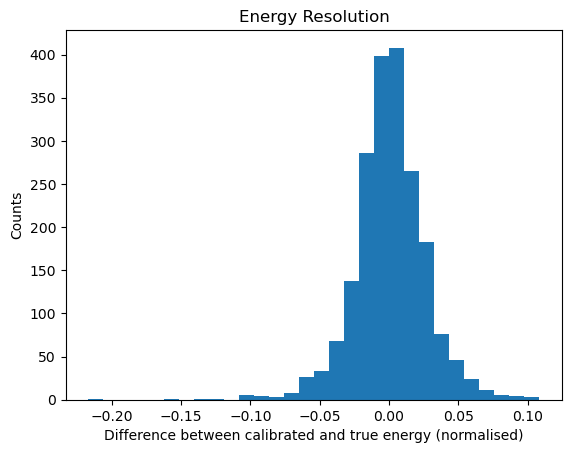

In [38]:
"""
Calibration of Entire Detector System - Similar to the code I used in workshop two, but I had to alter it quite
a bit as my experiment would occasionally return an inf value and I had to filter these data points out
"""
#From Here until the end of the for loop is effectively a filter to remove inf values
a = (Data['Generated']/(Data.iloc[:,1:].sum(axis=1)))
a_filtered = []
b_filtered = []
Truth_filtered = []
for i in range(len(a)):
    if a[i] <= 100000000000000:
        a_filtered.append(a[i])
        b_filtered.append(Data.iloc[:,1:].sum(axis=1)[i])
        #I also make sure the correct truth data is filtered so they still correspond to the correct events
        Truth_filtered.append(Data['Generated'][i])

#I take the mean of the filtered data to get my calibration constant
C = np.asarray(a_filtered).mean()

#Ecal/ETrue plot
hist = ((np.asarray(b_filtered) * C)-np.asarray(Truth_filtered))/np.asarray(Truth_filtered)
plt.hist(hist, bins = 30)
plt.title("Energy Resolution")
plt.xlabel("Difference between calibrated and true energy (normalised)")
plt.ylabel("Counts")
std_dev = np.std(hist)
print(np.mean(hist))
print("Total Detector resolution: " + str(std_dev))

#### Different Particles

Using the particle gun c++ code, I randomly shoot particles of different charge. By adding a magnetic field to my detector, I can use the tracking data from my silicon layers to determine the particle (by how it moves in the constant magnetic field). Using the c++ code I write to file the truth data, event ID as well as the phi and theta angles. This particular section was inspired by Example 3.

Once I had this data, I read everything to my python file where I performed my analysis. See below:

In [53]:
"""
Phi values are negative if charge is negative. Try and maybe use theta data to further prove the particle.
"""

FilteredPhi1 = []
FilteredPhi2 = []

FilteredTheta1 = []
FilteredTheta2 = []

FilteredTruth1ele = []
FilteredTruth1pos = []
FilteredTruth2ele = []
FilteredTruth2pos = []

for i in range(2000):
    #The below lines allow me to filter the particles at each event such that I am only looking at the first hit
    a = np.where(Silicon1Data['EventID'] == i)
    b = np.where(Silicon2Data['EventID'] == i)
    FilteredPhi1.append(Silicon1Data['Phi'][a[0][0]])
    FilteredPhi2.append(Silicon2Data['Phi'][b[0][0]])
    
    #Filtering my truth data, upon reflection I did not need to this as I read out truth data. For this task however
    #it won't affect the result, was just kind of a waste of my time
    if Silicon1Data['Phi'][a[0][0]] > 0:
        FilteredTruth1pos.append("e+")
    elif Silicon1Data['Phi'][a[0][0]] < 0:
        FilteredTruth1ele.append("e-")
        
    if Silicon2Data['Phi'][b[0][0]] > 0:
        FilteredTruth2pos.append("e+")
    elif Silicon2Data['Phi'][b[0][0]] < 0:  
        FilteredTruth2ele.append("e-")
    


## Section 3: Data Validation

#### Energy Resolution

See histogram above. I kind of do the reconstruction and validation at once

#### Particle Reconstruction


I started by saying I was only going to shoot electrons and positrons (would have also worked other particles with a opposite charge and mass) and then use the tracking data to determine their flight path. From here I would then be able to say whether they are electrons or positrons. I do view this as physical. I do not view it as particularly impressive, this only served as a sort of foundation to build on.

As these particles were very easily identifiable as they had opposite charge, the efficiency for each of them when doing correct/total was 100%. For me, improving on this section could actually involve lowering this number - as for a true detector experiment I would rather be able to classify a plethora of particles with 80-90% accuracy than two with 100%. That will come in the next section

In [54]:
positrons = 0
electrons = 0

#Counting my electrons and positrons
for i in range(len(FilteredPhi1)):
    if (FilteredPhi1[i] + FilteredPhi2[i]) <=0:
        electrons += 1
    else:
        positrons +=1

#This works succesfully. Note that I use the filterTruth variable rather than just the truth data directy.
#I think it should be clear with an understanding of magnetism that the result here would't change regardles
#as I am just saying what goes up and what goes down
print("e- classification efficiency: " + str(electrons/len(FilteredTruth1ele)))
print("e+ classification efficiency: " + str(positrons/len(FilteredTruth1pos)))

e- classification efficiency: 1.0
e+ classification efficiency: 1.0


The above is not a particularly impressive particle classification, but what it does do is lay a solid foundation that will allow me to open up my detector to more particles in the next section!

### Simple Structure Conclusion

So far I have built a simple detector experiment. I have used two calorimeter structures and a silicon tracking layer structure. Using these structures I have calculated an energy resolution, generated from an increasing energy of a couple orders of magnitude, and performed a classification task using the tracking data and magnetic field in order to seperate my electrons or positron.

Going forward, my idea of improvement would be to build my detector up to detect more particles, and investigate the different effects of material choice and particles on the resolution


## Section 4: Improvement

### Data Reconstruction Improvements

#### Particle Reconstruction and Data Validation

 My idea would for the improvement then be to expand the basic e-/e+ such that using more detailed analysis of the tracking data I could introduce quite a few differently charged particles and then try and seperate all of them based on their behaviour in the magnetic field. This would also better simulate a real environment which is nice. A final test I would also like to do is using radioactive decays. This could also provide me with different particles, and importantly as I know what source I would be using I would know the possible decays. This therefore to me also fits the criteria of physically reasonable, as I would know the source details of the particles

First of all, I am going to alter my code to shoot some different particles as well as the e+/e-. It is important that these particles have different charge to each other and e+/e-, otherwise it may prove extremely difficult to tell them apart. These particles I have chosen (for now) are: kaon+ and kaon-


In [6]:
"""
Here I have introduced k+ and k- to the mix, to see if I can seperate them. At a given event ID (and therefore energy) I can see that the 
kaons have a higher theta than the electrons/positrons. Use this to seperate them. These theta comes from interaction with silicon detector
This is also the reason why I then have occasional Silicon atoms hitting the detectors after words

Also have occasional pions and muons from decays. Maybe I can try and also classify them. Perhaps the neural network stuff could be better for that
When I do the neural network stuff I will also likely have to add in launch energy in order to seperate theta angles. - Launch energy not physical knowledge

Potentially alter the whole calorimeter structure such that it is easier to classify them - Finished.
Now what I can do try and determine where most of the energy is deposited for each particle. If say more than 40% is dumped in hadronic
calorimeter, I  make the claim its more likely a kaon.
"""

#Reading in the appropriate data. Im stood for improvement, but I go much further than this section
ImData = pd.read_csv('output_nt_Energy_dataImp1.csv', comment = '#' , \
                        names=['Generated', 'ECLayer1', 'ECLayer2', 'ECLayer3', 'ECLayer4', 'HCLayer1', 'HCLayer2', 'HCLayer3', 'HCLayer4', 'HCLayer5', 'HCLayer6'])


ImSilicon1Data = pd.read_csv('output_nt_Silicon1DataImp1.csv', comment = '#', \
                           names=['Truth', 'EventID', 'Phi', 'Theta'])
    
ImSilicon2Data = pd.read_csv('output_nt_Silicon2DataImp1.csv', comment = '#', \
                           names=['Truth','EventID', 'Phi', 'Theta'])


#Again up until C I do my no inf filter
a = (ImData['Generated']/(ImData.iloc[:,1:].sum(axis=1)))
a_filtered = []
b_filtered = []
Truth_filtered = []
for i in range(len(a)):
    if a[i] <= 100000000000000:
        #Sometimes I would get inf values, the above filters that out
        a_filtered.append(a[i])
        b_filtered.append(ImData.iloc[:,1:].sum(axis=1)[i])
        Truth_filtered.append(ImData['Generated'][i])

#This data is split by event ID by default, simplifying things later
C = np.asarray(a_filtered).mean()    
#I am not after the plot here, I just want my calibrated energy
Final_filtered = C * np.asarray(b_filtered)

FilteredPhi1 = []
FilteredPhi2 = []

FilteredTheta1 = []
FilteredTheta2 = []

FilteredTruth1ele = []
FilteredTruth1pos = []
FilteredTruth1kplus = []
FilteredTruth1kmin = []

FilteredTruth2ele = []
FilteredTruth2pos = []
FilteredTruth2kplus = []
FilteredTruth2kmin = []

#Splitting into energy regimes
#print(ImData.iloc[0,1:5].sum())
#print(ImData.iloc[0,5:].sum())
E_em = []
E_hc = []
for i in range(2000):
    E_em.append(ImData.iloc[i,1:5].sum())
    E_hc.append(ImData.iloc[i,5:].sum())
    
#print(E_em[0], E_em[1])

#Splitting into charge regimes
for i in range(2000):
    #Loop to find the phi values for all the input particles
    a = np.where(ImSilicon1Data['EventID'] == i)
    b = np.where(ImSilicon2Data['EventID'] == i)
 
    FilteredPhi1.append(ImSilicon1Data['Phi'][a[0][0]])
    FilteredPhi2.append(ImSilicon2Data['Phi'][b[0][0]])

positrons = 0
electrons = 0
kaonplus = 0
kaonmin = 0

for i in range(len(FilteredPhi1)):
    #Conditions to seperate particles based on their angle and where they deposit most of their energy
    if ((FilteredPhi1[i] + FilteredPhi2[i]) > 0) and (E_em[i] > E_hc[i]):
        positrons += 1
    elif ((FilteredPhi1[i] + FilteredPhi2[i]) > 0) and (E_em[i] < E_hc[i]):
        kaonplus += 1
    elif ((FilteredPhi1[i] + FilteredPhi2[i]) < 0) and (E_em[i] > E_hc[i]):
        electrons += 1
    elif ((FilteredPhi1[i] + FilteredPhi2[i]) < 0) and (E_em[i] < E_hc[i]):
        kaonmin += 1
        
tot = positrons + electrons + kaonplus + kaonmin
#Sanity check that I am indeed seeing 2000 particles. Now I need to compare them with truth. Also tells me that having both calorimeters was a good idea
print(positrons, electrons, kaonplus, kaonmin)
print(positrons + electrons + kaonplus + kaonmin)

Truth = []
for i in range(2000):
    #Filtering my Truth data
    a = np.where(ImSilicon1Data['EventID'] == i)
    Truth.append(ImSilicon1Data['Truth'][a[0][0]])


True_pos = 0
True_ele = 0
True_kplu = 0
True_kneg = 0

for i in range(2000):
    #Counting how many true particles I have of each type
    if Truth[i] == 'e-':
        True_ele += 1
    if Truth[i] == 'e+':
        True_pos += 1
    if Truth[i] == 'kaon+':
        True_kplu += 1
    if Truth[i] == 'kaon-':
        True_kneg += 1

        
#This result is key, I know that sometimes we have muons or pions and as of such do not expect to always see one of the four particles 
True_tot = True_pos + True_ele + True_kplu + True_kneg

#Printing efficiency ratios
print("e- efficiecy: " + str(electrons/True_ele))
print("e+ efficiency: " + str(positrons/True_pos))
print("kaon+ efficiency: " + str(kaonplus/True_kplu))
print("kaon- efficiency: " + str(kaonmin/True_kneg))
print("Total efficiency: " + str(tot/True_tot))

528 593 462 417
2000
e- efficiecy: 1.6246575342465754
e+ efficiency: 1.5172413793103448
kaon+ efficiency: 0.7368421052631579
kaon- efficiency: 0.6536050156739812
Total efficiency: 1.0111223458038423


As can be seen, this method does have some flaws. The system is still excellent at identifying electrons and positrons. It does however count a lot kaons as e+ or e-. My goal, for now, is to try and get both kaon efficiencies up to around 85% minimum. My total efficiency will always be a little higher than 1 due to the muons and pions observed in the system I am choosing to ignore for now. Perhaps I can later alter the code to filter them out. 
I intend to improve this by fitting a variable such that instead of comparing E_hc and E_em I will compare f*E_hc with E_em. The idea is to find the optimal comparison point that seperates them

In [7]:
"""
First test was to change the fraction of energy required for classification. What I want to do
here is use a regressional method to find the point at which the kaon+ + kaon- total efficiency
is greatest. At this point the electron/positron efficiency rates should also bet at their closest
to one. 
"""
kaonplus = 0
kaonmin = 0
#Create an array of values between 0 and 10, I will multiply E_hc by this. The idea is I can find the fraction of energy
#in each calorimeter that will yield me the best comparisons
f = np.linspace(1, 10, 1000)
index = []

#We want the combined efficiency to be as close to 2 as possible
kefficiency = []



for j in range(len(f)):
    kaonplus = 0
    kaonmin = 0
    for i in range(len(FilteredPhi1)):    
        if ((FilteredPhi1[i] + FilteredPhi2[i]) > 0) and (E_em[i] < f[j]*E_hc[i]):
            kaonplus += 1
        elif ((FilteredPhi1[i] + FilteredPhi2[i]) < 0) and (E_em[i] < f[j]*E_hc[i]):
            kaonmin += 1
    #Calculating my efficiency for each f value        
    kefficiency.append((kaonplus/True_kplu) + (kaonmin/True_kneg))
    index.append(j)  

#finding my best efficiency, and the f value it corresponds to
bestK = min(kefficiency, key=lambda x:abs(x-2))
loc = kefficiency.index(bestK)

#Grabbing the best f
bestf = f[loc]

positrons = 0
electrons = 0
kaonplus = 0
kaonmin = 0

#redoing my classification
for i in range(len(FilteredPhi1)):
    if ((FilteredPhi1[i] + FilteredPhi2[i]) > 0) and (E_em[i] > bestf*E_hc[i]):
        positrons += 1
    elif ((FilteredPhi1[i] + FilteredPhi2[i]) > 0) and (E_em[i] < bestf*E_hc[i]):
        kaonplus += 1
    elif ((FilteredPhi1[i] + FilteredPhi2[i]) < 0) and (E_em[i] > bestf*E_hc[i]):
        electrons += 1
    elif ((FilteredPhi1[i] + FilteredPhi2[i]) < 0) and (E_em[i] < bestf*E_hc[i]):
        kaonmin += 1

#Making sure this hasn't changed
tot = positrons + electrons + kaonplus + kaonmin

#printing efficiency ratios
print("BestF: " + str(bestf))        
print("e- efficiecy: " + str(electrons/True_ele))
print("e+ efficiency: " + str(positrons/True_pos))
print("kaon+ efficiency: " + str(kaonplus/True_kplu))
print("kaon- efficiency: " + str(kaonmin/True_kneg))
print("Total efficiency: " + str(tot/True_tot))

BestF: 3.963963963963964
e- efficiecy: 1.0438356164383562
e+ efficiency: 1.0201149425287357
kaon+ efficiency: 1.0127591706539074
kaon- efficiency: 0.9858934169278997
Total efficiency: 1.0111223458038423


The above fitting for the fraction worked quite well. I now want to compare the above classifications results to that generated by a neural network. I think looking at this a couple kaon- are still being identified as e-, and the miscellaneous particles in the system from decays and stuff is what is causing excess particles to appear. I.e. pi+ will be getting mistaken for e+ or kaon+. Note that I am not shooting these, they seem to be coming from decays or something

Neural Network Design.

Inputs = Phi1 ,
         Theta1 ,
         Phi2.
         Theta2
         Total energy detected by detectors ,
         Total energy detected in detector 1,
         Total energy detetcted in detector 2
         
         
outputs = Particle type


In [8]:
#I have had to do this every workshop for some reason even after installing things.
#!pip install tensorflow

In [9]:
#A load of imports from previous workshops that may or may not prove useful
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split


In [10]:
#A load of imports from previous workshops that may or may not prove useful
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.wrappers.scikit_learn import KerasRegressor
from tensorflow.keras.utils import to_categorical

2023-03-23 19:48:48.502493: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-23 19:48:49.527421: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-03-23 19:48:52.895172: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [11]:
#First, some data preprocessing

def preprocessing(Edata, Tracker1, Tracker2, datatype):
    ticker= 0
    
    #Read in the files I wish to preprocess
    NNData = pd.read_csv(Edata, comment = '#' , \
                            names=['Generated', 'ECLayer1', 'ECLayer2', 'ECLayer3', 'ECLayer4', 'HCLayer1', 'HCLayer2', 'HCLayer3', 'HCLayer4', 'HCLayer5', 'HCLayer6'])


    NNSilicon1Data = pd.read_csv(Tracker1, comment = '#', \
                               names=['Truth', 'EventID', 'Phi', 'Theta'])

    NNSilicon2Data = pd.read_csv(Tracker2, comment = '#', \
                               names=['Truth','EventID', 'Phi', 'Theta'])

    E_em = []
    E_hc = []
    E_tot = []
    FilteredPhi1 = []
    FilteredPhi2 = []

    #Also going to take into account theta as well. There is a difference with theta at similar launch energies with the different mass particles. This didn't prove much
    #of a difference for my manual classification, but perhaps it will help the NN

    FilteredTheta1 = []
    FilteredTheta2 = []

    #We are only interested in the first particle that hits the detector in each event
    FilteredTrue_part = []

    for i in range(len(NNData)):
        ticker += 1
        if ticker%1000 == 0:
            #print("Loading")
            pass
        
        a = np.where(NNSilicon1Data['EventID'] == i)
        b = np.where(NNSilicon2Data['EventID'] == i)
        
        if len(a[0]) < 1 or len(b[0]) < 1:
            pass
        else:
            
        
            E_em.append(NNData.iloc[i,1:5].sum())
            E_hc.append(NNData.iloc[i,5:].sum())
            E_tot.append(NNData.iloc[i, 1:].sum())


            FilteredPhi1.append(NNSilicon1Data['Phi'][a[0][0]])
            FilteredPhi2.append(NNSilicon2Data['Phi'][b[0][0]])

            FilteredTheta1.append(NNSilicon1Data['Theta'][a[0][0]])
            FilteredTheta2.append(NNSilicon2Data['Theta'][b[0][0]])

            FilteredTrue_part.append(NNSilicon1Data['Truth'][a[0][0]])
        
        #Creating my input data based on my filtered values
        input_data = pd.DataFrame(list(zip(E_em, E_hc, E_tot, FilteredPhi1, FilteredPhi2, FilteredTheta1, FilteredTheta2)),
                                  columns=['EMCal Energy', 'HadCal Energy', 'TotalDetect Energy', 'Phi1', 'Phi2', 'Theta1', 'Theta2'])

    #This is for the four known particle setup
    if datatype == 1:
        for i in range(len(FilteredTrue_part)):
            ticker += 1
            if ticker%1000 == 0:
                #print("Loading")
                pass
            if FilteredTrue_part[i] == 'e-':
                FilteredTrue_part[i] = 0
            elif FilteredTrue_part[i] == 'e+':
                FilteredTrue_part[i] = 1
            elif FilteredTrue_part[i] == 'kaon-':
                FilteredTrue_part[i] = 2
            elif FilteredTrue_part[i] == 'kaon+':
                FilteredTrue_part[i] = 3
            else: 
                FilteredTrue_part[i] = 4
        #one hot encoding my target variables
        encoded = to_categorical(FilteredTrue_part, num_classes=5)
                
    #This is for the 10 known particle setup
    elif datatype == 2:
        for i in range(len(FilteredTrue_part)):
            ticker += 1
            if ticker%1000 == 0:
                #print("Loading")
                pass
            if FilteredTrue_part[i] == 'e-':
                FilteredTrue_part[i] = 0
            elif FilteredTrue_part[i] == 'e+':
                FilteredTrue_part[i] = 1
            elif FilteredTrue_part[i] == 'kaon-':
                FilteredTrue_part[i] = 2
            elif FilteredTrue_part[i] == 'kaon+':
                FilteredTrue_part[i] = 3
            elif FilteredTrue_part[i] == 'muon+':
                FilteredTrue_part[i] = 4
            elif FilteredTrue_part[i] == 'muon-':
                FilteredTrue_part[i] = 5
            elif FilteredTrue_part[i] == 'pion+':
                FilteredTrue_part[i] = 6
            elif FilteredTrue_part[i] == 'pion-':
                FilteredTrue_part[i] = 7
            elif FilteredTrue_part[i] == 'gamma':
                FilteredTrue_part[i] = 8
            elif FilteredTrue_part[i] == 'neutron':
                FilteredTrue_part[i] = 9
            else:
                FilteredTrue_part[i] = 10
        #one-hot encoding my target labels
        encoded = to_categorical(FilteredTrue_part, num_classes=11)

        
    
    #This below block taken from workshop example (week 8 I believe)
    from sklearn import model_selection, preprocessing
    #Using MinMaxScaler allows consistency at higher energy scales - what we did for project 2
    sc = preprocessing.MinMaxScaler()

    target = encoded
    input_data = sc.fit_transform(input_data)


    #input_data = sc.fit_transform( input_data )
    # set random seed
    seed= 42
    # train - test split of dataset
    train_data , test_data , train_target , test_target = model_selection.train_test_split(\
    input_data , target , test_size =0.1 , random_state = seed )
    print (train_data.shape , train_target.shape , test_data.shape , test_target.shape )

    return train_data, test_data, train_target, test_target

#The files I want to use
file1 = 'output_nt_Energy_dataNN1.csv'
file2 = 'output_nt_Silicon1DataNN1.csv'
file3 = 'output_nt_Silicon2DataNN1.csv'

train_data1, test_data1, train_target1, test_target1 = preprocessing(file1, file2, file3, 1)




(3585, 7) (3585, 5) (399, 7) (399, 5)


In [12]:
def my_model(num_inputs , num_nodes , extra_depth, num_outputs ):
    # create model - this function taken from week 9 content
    model = Sequential()
    model.add(Dense(num_nodes , input_dim = num_inputs , kernel_initializer = 'normal' , activation = 'relu' ))
    model.add(Dropout (0.2))
    for i in range ( extra_depth ):
        model.add(Dense(num_nodes , input_dim = num_inputs , kernel_initializer = 'normal' , activation = 'relu' ))
        
    model.add(Dense(num_outputs , activation = 'softmax' ))
    
    # Compile model
    model.compile( loss = 'categorical_crossentropy' , optimizer = 'adam' , metrics = ['accuracy'])
    return model

#Just chose random node number, layer number, batchsize and epochs, seemed to work well
Model = my_model(7, 20, 1, 5)
#
batchSize = 16
N_epochs = 50
#Training as required - didn't implement early stopping as the difference made would be near negligible
History = Model.fit(train_data1 ,train_target1 ,batch_size = batchSize , epochs = N_epochs , verbose =1 , validation_data=(test_data1 , test_target1 ))

Epoch 1/50
225/225 [==============================] - 2s 4ms/step - loss: 1.3569 - accuracy: 0.4881 - val_loss: 0.9029 - val_accuracy: 0.6767
Epoch 2/50
225/225 [==============================] - 1s 3ms/step - loss: 0.7723 - accuracy: 0.7074 - val_loss: 0.5979 - val_accuracy: 0.8596
Epoch 3/50
225/225 [==============================] - 1s 2ms/step - loss: 0.5638 - accuracy: 0.7877 - val_loss: 0.4063 - val_accuracy: 0.8722
Epoch 4/50
225/225 [==============================] - 1s 3ms/step - loss: 0.4237 - accuracy: 0.8460 - val_loss: 0.2968 - val_accuracy: 0.9048
Epoch 5/50
225/225 [==============================] - 1s 3ms/step - loss: 0.3399 - accuracy: 0.8753 - val_loss: 0.2381 - val_accuracy: 0.9173
Epoch 6/50
225/225 [==============================] - 1s 3ms/step - loss: 0.2974 - accuracy: 0.8962 - val_loss: 0.2102 - val_accuracy: 0.9173
Epoch 7/50
225/225 [==============================] - 1s 3ms/step - loss: 0.2748 - accuracy: 0.9068 - val_loss: 0.1938 - val_accuracy: 0.9223
Epoch 

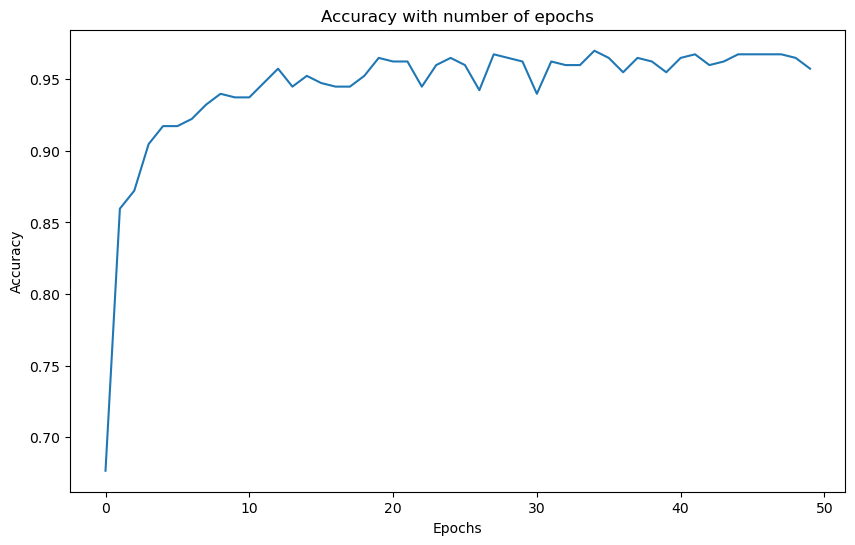

In [13]:
#Plotting my accuracy
plt.figure(figsize=(10,6))
plt.plot(History.history['val_accuracy'])
plt.title('Accuracy with number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

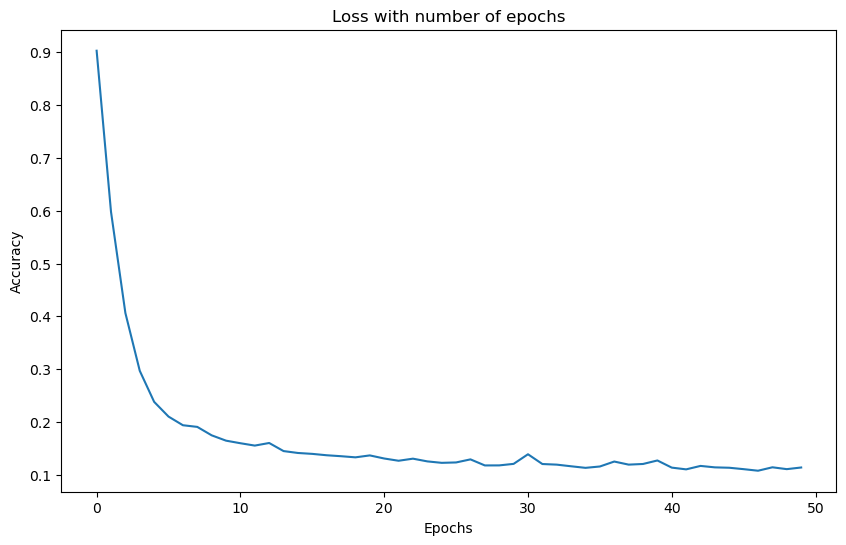

In [14]:
#Plotting my Loss
plt.figure(figsize=(10,6))
plt.plot(History.history['val_loss'])
plt.title('Loss with number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

I now know that using the machine learning approaches is a valid method. I would not say that it necessarily offered a big improvement, but what I can now do is alter my particle gun such that I have many more particles than 4. 4 Particles are pretty easy to classify manually, but I imagine it will prove quite difficult with like 8+ particles. Let's see if a neural network can do it. I am also going to alter the energy gun here a little bit for time sake, once it reaches a certain value I am going to reset it back to what it started at. I scale my data anyway so this shouldn't affect results, I'd just rather have the simulation finished sooner than later. I will also increase my simulation number. I will try get like 30000 or so and just run it over night, at the sacrifice of my laptop fan sounding like it is about to take off all night.

In [15]:
file1 = 'output_nt_Energy_dataNN2.csv'
file2 = 'output_nt_Silicon1DataNN2.csv'
file3 = 'output_nt_Silicon2DataNN2.csv'

#This takes quite a long time to run as it is quite a large csv file and I do quite a bit of processing (~30000 events or something)
train_data2, test_data2, train_target2, test_target2 = preprocessing(file1, file2, file3, 2)


(23026, 7) (23026, 11) (2559, 7) (2559, 11)


In [16]:
Model2 = my_model(7, 40, 2, 11)

batchSize = 64
N_epochs = 50
#Training as required
History2 = Model2.fit(train_data2 ,train_target2 ,batch_size = batchSize , epochs = N_epochs , verbose =1 , validation_data=(test_data2 , test_target2 ))

Epoch 1/50
360/360 [==============================] - 2s 3ms/step - loss: 0.5977 - accuracy: 0.8566 - val_loss: 0.2501 - val_accuracy: 0.9144
Epoch 2/50
360/360 [==============================] - 1s 3ms/step - loss: 0.2262 - accuracy: 0.9263 - val_loss: 0.1944 - val_accuracy: 0.9308
Epoch 3/50
360/360 [==============================] - 1s 3ms/step - loss: 0.1748 - accuracy: 0.9394 - val_loss: 0.1623 - val_accuracy: 0.9390
Epoch 4/50
360/360 [==============================] - 1s 3ms/step - loss: 0.1565 - accuracy: 0.9446 - val_loss: 0.1535 - val_accuracy: 0.9457
Epoch 5/50
360/360 [==============================] - 1s 3ms/step - loss: 0.1499 - accuracy: 0.9460 - val_loss: 0.1545 - val_accuracy: 0.9418
Epoch 6/50
360/360 [==============================] - 1s 3ms/step - loss: 0.1462 - accuracy: 0.9466 - val_loss: 0.1498 - val_accuracy: 0.9445
Epoch 7/50
360/360 [==============================] - 1s 3ms/step - loss: 0.1427 - accuracy: 0.9465 - val_loss: 0.1409 - val_accuracy: 0.9480
Epoch 

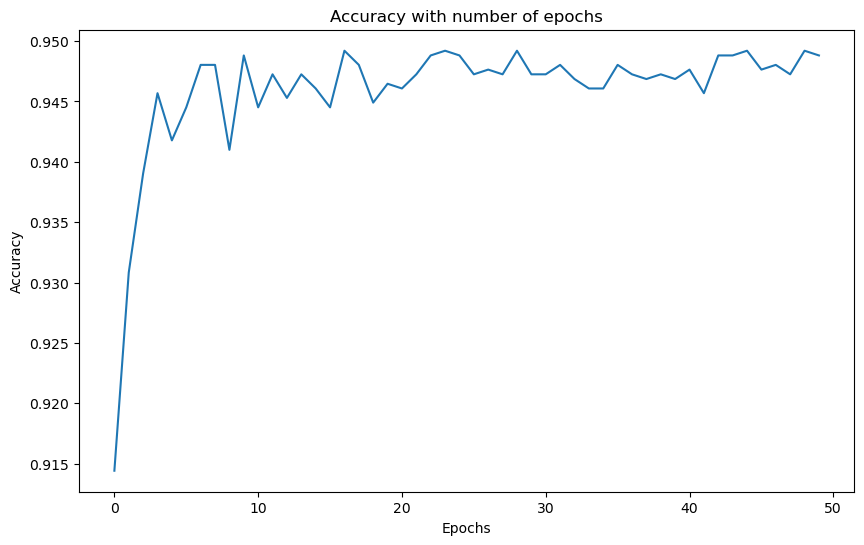

In [17]:
plt.figure(figsize=(10,6))
plt.plot(History2.history['val_accuracy'])
plt.title('Accuracy with number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

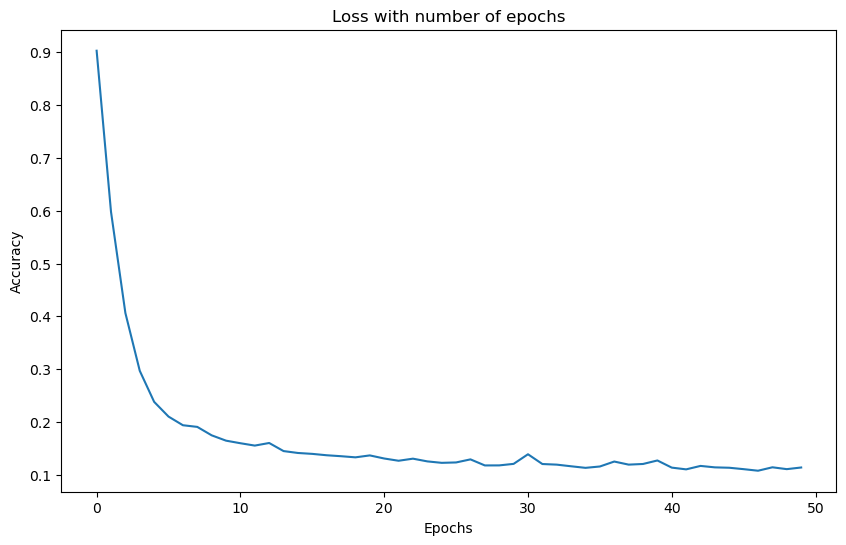

In [18]:
plt.figure(figsize=(10,6))
plt.plot(History.history['val_loss'])
plt.title('Loss with number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

The detector provides enough detail through the silicon tracking layers and deposited energy in the calorimeters that it is possible to seperate a wide range of particles. I do not think I myself could come up with a function to classify this many particles better than this, so as best to my knowledge this is currently as good as I will get for the classification section. Around 95% accuracy for 10 different particles (and also whatever else hits the detectors) seems pretty good to me, and I am satisfied with this. I don't get better classification efficiency with more particles, but it doesn't get worse. This to me is a massive, as it would represent something far more practical<br>

When doing this bit, I have ignored my energy resolution. Let's return to that

## Important Note

This next section is going to be a lot of me trying to improve the detector resolution. Some of my discussion here when I start comparing different materials involves me not realising I am looking at ok resolution values. I figure this out eventually, and make appropriate commentary on it, but just a heads up. I chose to leave all that discussion as I still think I tried some interesting things and I believe it is good having these things accompanied by my thoughts at the time.

This next section is also a lot of trial and error, the gist of it is I try a load of different material combinations and scales for my calorimeter setup. I eventually get to a decent result, but apologise as a lot of it is it was a slow process and perhaps not the most interesting.

To make up for it I plan to try and do some more interesting, albeit less useful things after.


In [19]:
Data = pd.read_csv('output_nt_Energy_dataNN2.csv', comment = '#' , \
                        names=['Generated', 'ECLayer1', 'ECLayer2', 'ECLayer3', 'ECLayer4', 'HCLayer1', 'HCLayer2', 'HCLayer3', 'HCLayer4', 'HCLayer5', 'HCLayer6'])


Total Detector resolution: 32.20638350741885


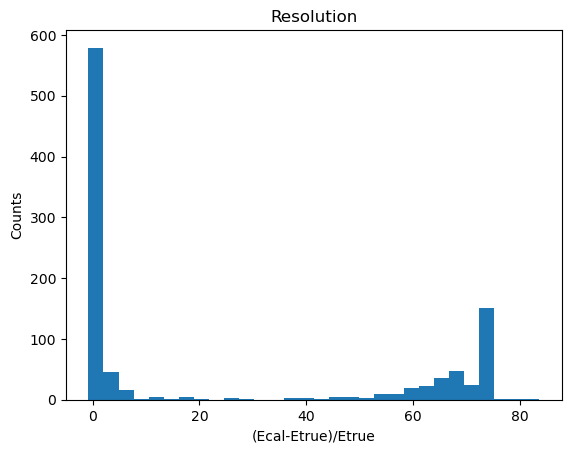

In [51]:
"""
Calibration of Entire Detector System - using method at the beginning
"""

a = (Data['Generated']/(Data.iloc[:,1:].sum(axis=1)))
a_filtered = []
b_filtered = []
Truth_filtered = []
for i in range(len(a)):
    if a[i] <= 100000000000000:
        a_filtered.append(a[i])
        b_filtered.append(Data.iloc[:,1:].sum(axis=1)[i])
        Truth_filtered.append(Data['Generated'][i])

C = np.asarray(a_filtered).mean()

hist = ((np.asarray(b_filtered) * C)-np.asarray(Truth_filtered))/np.asarray(Truth_filtered)
plt.title("Resolution")
plt.xlabel("(Ecal-Etrue)/Etrue")
plt.ylabel("Counts")
plt.hist(hist, bins = 30)
std_dev = np.std(hist)
print("Total Detector resolution: " + str(std_dev))

Uh-oh, clearly the energy detection part of the program struggles when lots of different particles are used. Let's try and fix this

In [21]:
print(Data['Generated'])

0         1000
1         1100
2         1200
3         1300
4         1400
         ...  
29310    41000
29311    41100
29312    41200
29313    41300
29314    41400
Name: Generated, Length: 29315, dtype: int64


In [22]:
Data.iloc[:,1:].sum(axis=1)

0          768.177110
1          709.584475
2          929.133580
3          790.674400
4         1151.686500
             ...     
29310    27162.224000
29311    11304.365500
29312    26256.604400
29313    26909.215000
29314    27170.407800
Length: 29315, dtype: float64

It would seem that a lot of the energy is being lost. I think to solve this, we must have a look at the structure of our detector. I am first going to try make my detector layers thicker, from 10.0cm to 25.0cm. Due to time constraints, I am only going to run 1000 times, but I will alter my particle gun so I still get two orders of magnitude. Note: I am also going to double the radius of my detectors, the magnetic field could be pushing particles out of the detector from the side which would stop everything being absorbed.

Also as a note, I am always losing energy. 

In [49]:
Data = pd.read_csv('output_nt_Energy_dataRes1.csv', comment = '#' , \
                        names=['Generated', 'ECLayer1', 'ECLayer2', 'ECLayer3', 'ECLayer4', 'HCLayer1', 'HCLayer2', 'HCLayer3', 'HCLayer4', 'HCLayer5', 'HCLayer6'])


Total Detector resolution: 32.20638350741885


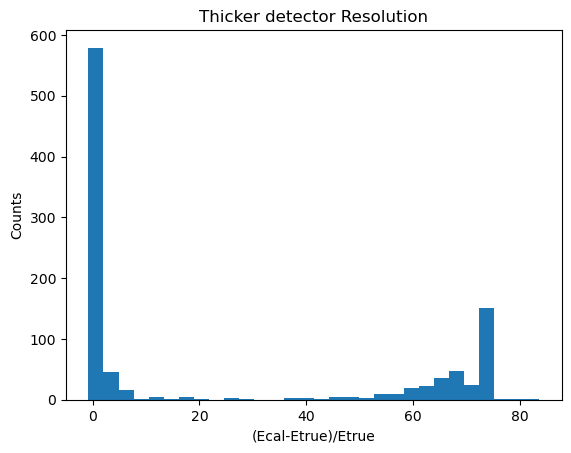

In [50]:
"""
Calibration of Entire Detector System - using method at the beginning - I am going to note here I did eventually just build
a function for this, but it does come later.
"""

a = (Data['Generated']/(Data.iloc[:,1:].sum(axis=1)))
a_filtered = []
b_filtered = []
Truth_filtered = []
for i in range(len(a)):
    if a[i] <= 100000000000000:
        a_filtered.append(a[i])
        b_filtered.append(Data.iloc[:,1:].sum(axis=1)[i])
        Truth_filtered.append(Data['Generated'][i])

C = np.asarray(a_filtered).mean()

hist = ((np.asarray(b_filtered) * C)-np.asarray(Truth_filtered))/np.asarray(Truth_filtered)



plt.hist(hist, bins = 30)
plt.title("Thicker detector Resolution")
plt.xlabel("(Ecal-Etrue)/Etrue")
plt.ylabel("Counts")
std_dev = np.std(hist)
print("Total Detector resolution: " + str(std_dev))

Some success - albeit still brutally far from where I want to be! It would appear this did help a bit, there seems to be still quite block around the 60 block. For my next test, I am  going to increase the EM calorimeter to 6 layers, and the HC up to 10. 

In [25]:
Data = pd.read_csv('output_nt_Energy_dataRes2.csv', comment = '#' , \
                        names=['Generated', 'ECLayer1', 'ECLayer2', 'ECLayer3', 'ECLayer4', 'ECLayer5', 'ECLayer6', 'HCLayer1', 'HCLayer2', 'HCLayer3', 'HCLayer4', 'HCLayer5', 'HCLayer6', 'HCLayer7', 'HCLayer8', 'HCLayer9', 'HCLayer10'])

Total Detector resolution: 16.330305954638902


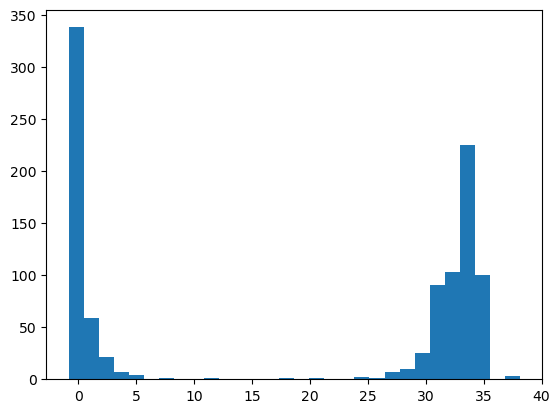

In [27]:
"""
Calibration of Entire Detector System - using method at the beginning
"""

a = (Data['Generated']/(Data.iloc[:,1:].sum(axis=1)))
a_filtered = []
b_filtered = []
Truth_filtered = []
for i in range(len(a)):
    if a[i] <= 100000000000000:
        a_filtered.append(a[i])
        b_filtered.append(Data.iloc[:,1:].sum(axis=1)[i])
        Truth_filtered.append(Data['Generated'][i])

C = np.asarray(a_filtered).mean()

hist = ((np.asarray(b_filtered) * C)-np.asarray(Truth_filtered))/np.asarray(Truth_filtered)
plt.title("Bigger Calorimeter Resolution")
plt.xlabel("(Ecal-Etrue)/Etrue")
plt.ylabel("Counts")
plt.hist(hist, bins = 30)
std_dev = np.std(hist)
print("Total Detector resolution: " + str(std_dev))

It appears that this did make a difference. I am however seeing two clear peaks. This suggests to me that something is going wrong with the hadronic calorimeter. We seen that the electromagnetic calorimeter works fine, as shown in the starting example with electrons and positrons.

I wanted to try quite a few different materials, but of course time is limited here and these simulations take a while. What I am going to do is increase the energy at a much lower rate. I will do 1000 simulations for each material type

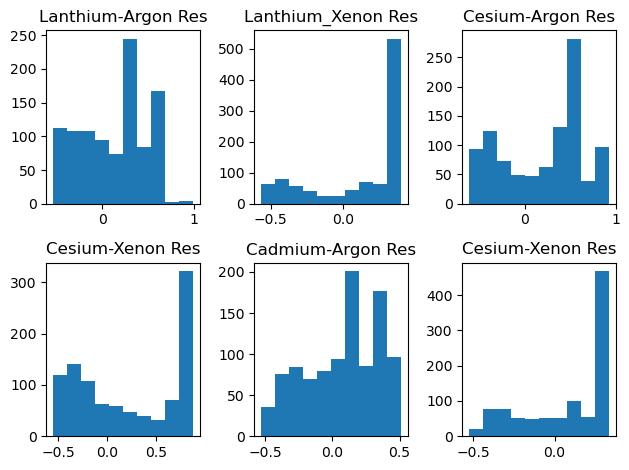

(array([175., 225., 131.,  43.,  49.,  18.,  44.,  74., 170.,  71.]),
 array([-0.83099024, -0.45352013, -0.07605002,  0.30142009,  0.6788902 ,
         1.05636031,  1.43383042,  1.81130053,  2.18877064,  2.56624075,
         2.94371086]),
 <BarContainer object of 10 artists>)

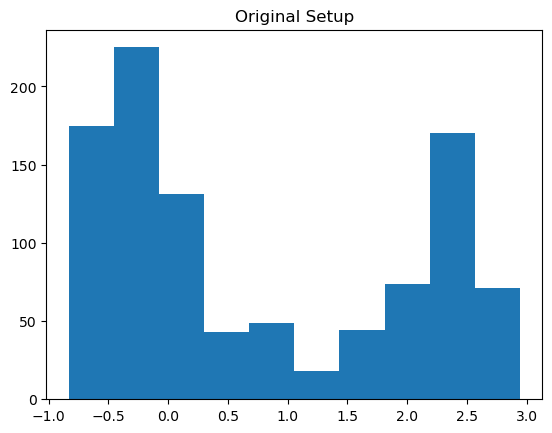

In [30]:
def calibrator(file1):
    Data = pd.read_csv(file1, comment = '#' , \
                        names=['Generated', 'ECLayer1', 'ECLayer2', 'ECLayer3', 'ECLayer4', 'ECLayer5', 'ECLayer6', 'HCLayer1', 'HCLayer2', 'HCLayer3', 'HCLayer4', 'HCLayer5', 'HCLayer6', 'HCLayer7', 'HCLayer8', 'HCLayer9', 'HCLayer10'])
    
    a = (Data['Generated']/(Data.iloc[:,1:].sum(axis=1)))
    a_filtered = []
    b_filtered = []
    Truth_filtered = []
    for i in range(len(a)):
        if a[i] <= 100000000000000:
            a_filtered.append(a[i])
            b_filtered.append(Data.iloc[:,1:].sum(axis=1)[i])
            Truth_filtered.append(Data['Generated'][i])

    C = np.asarray(a_filtered).mean()

    hist = ((np.asarray(b_filtered) * C)-np.asarray(Truth_filtered))/np.asarray(Truth_filtered)
    return hist

PlArhist = calibrator('output_nt_Energy_dataPA.csv')
LaArhist = calibrator('output_nt_Energy_dataLA.csv')
LaXehist = calibrator('output_nt_Energy_dataLX.csv')
CeArhist = calibrator('output_nt_Energy_dataCeA.csv')
CeXehist = calibrator('output_nt_Energy_dataCeX.csv')
CaArhist = calibrator('output_nt_Energy_dataCaA.csv')
CaXehist = calibrator('output_nt_Energy_dataCaX.csv')       

hists = [PlArhist, LaArhist, LaXehist, CeArhist, CeXehist, CaArhist, CaXehist]
titles = ['Orignal setup','Lanthium-Argon Res', 'Lanthium_Xenon Res', 'Cesium-Argon Res', 'Cesium-Xenon Res', 'Cadmium-Argon Res', 'Cesium-Xenon Res']

f,a = plt.subplots(2,3)
a = a.ravel()
for idx,ax in enumerate(a):
    ax.hist(hists[idx+1])
    ax.set_title(titles[idx+1])
plt.tight_layout()
plt.show()

plt.title('Original Setup')
plt.hist(hists[0])


Based on the above graph, I think it may be that the energies being used for this system are just too strenuous. Currently I am blasting my poor detector with particles moving with 500GeV or something and as a result I think they are just going straight through it. I seen in the subplots that at lower energies the cadmium-argon material combination works well, but I think the energy scale I am currently using is too much for the system As a result I am instead going to try order ~100MeV to ~10GeV instead of going to ~100GeV. I will also be using the Cadmium-Argon model as this looked decent

Total Detector resolution: 1.0424549555016034


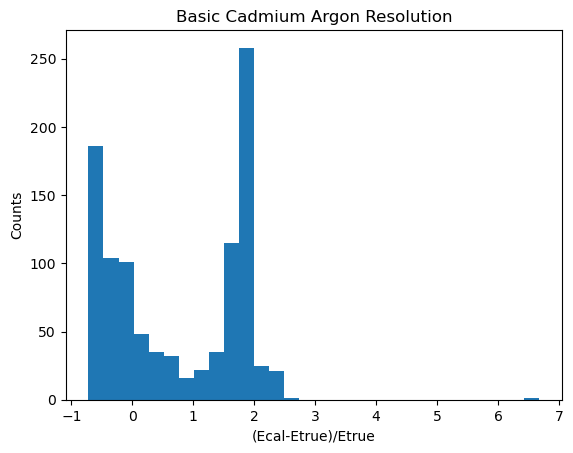

In [47]:
CeArhist3 = calibrator('output_nt_Energy_dataAe3.csv')
plt.title("Basic Cadmium Argon Resolution")
plt.xlabel("(Ecal-Etrue)/Etrue")
plt.ylabel("Counts")
plt.hist(CeArhist3, bins = 30);
std_dev = np.std(CeArhist3)
print("Total Detector resolution: " + str(std_dev))

Looks somewhat better, though there still remains the issue of the heavier particles blasting through the system. Going to try lead as the absorber instead of steel.


0.5033275899523532
Total Detector resolution: 0.6412545750781709


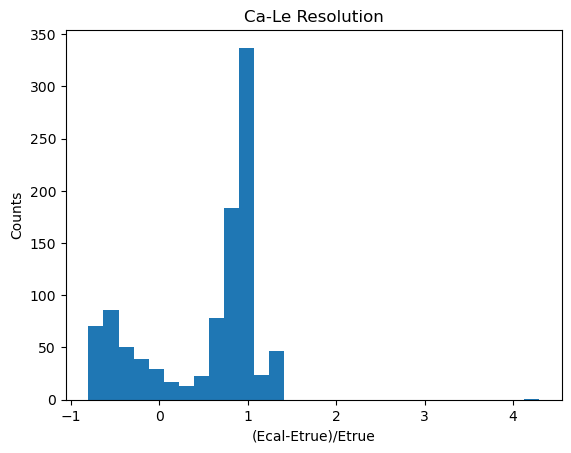

In [46]:
CeLehist1 = calibrator('output_nt_Energy_dataCL.csv')
plt.title("Ca-Le Resolution ")
plt.xlabel("(Ecal-Etrue)/Etrue")
plt.ylabel("Counts")
plt.hist(CeLehist1, bins = 30);
std_dev = np.std(CeLehist1)
print(np.mean(CeLehist1))
print("Total Detector resolution: " + str(std_dev))

For sure an improvement I now just have the issue of trying to shift that peak onto 0. Looking at my data, I still think it is a case of my hadronic layers not being able to catch enough. I am as of such going to try double the thicknesses of all layers and see what happens.

0.14028679458160953
Total Detector resolution: 0.3076215037036404


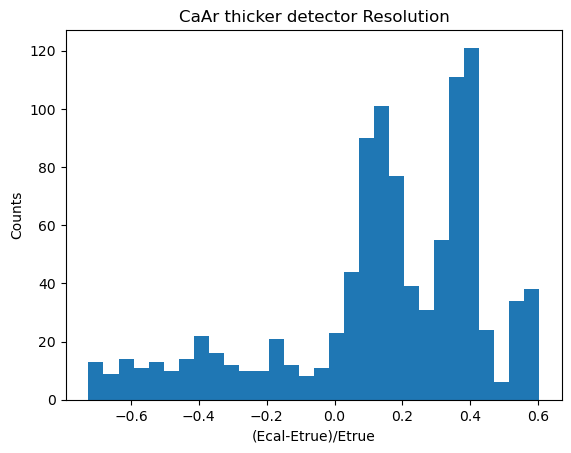

In [45]:
CeLehist2 = calibrator('output_nt_Energy_dataCl2.csv')
plt.title("CaAr thicker detector Resolution")
plt.xlabel("(Ecal-Etrue)/Etrue")
plt.ylabel("Counts")
plt.hist(CeLehist2, bins = 30);
std_dev = np.std(CeLehist2)
print(np.mean(CeLehist2))
print("Total Detector resolution: " + str(std_dev))

#### Almost there !- Going to just add a load more hadronic calorimeter layers and see what happens

0.17127633454969007
Total Detector resolution: 0.22788192227494308


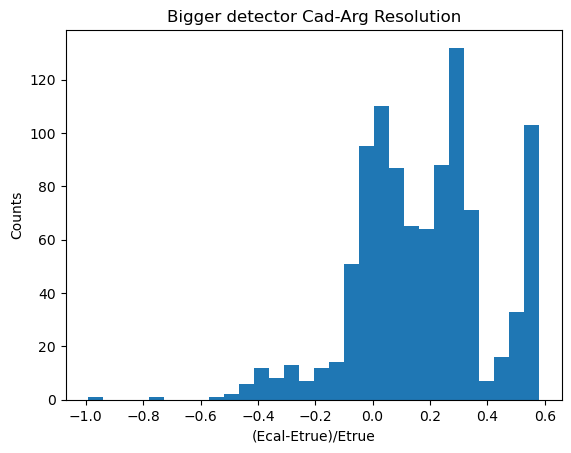

In [42]:
def calibrator2(file1):
    Data = pd.read_csv(file1, comment = '#' , \
                        names=['Generated', 'ECLayer1', 'ECLayer2', 'ECLayer3', 'ECLayer4', 'ECLayer5', 'ECLayer6', 'HCLayer1', 'HCLayer2', 'HCLayer3', 'HCLayer4', 'HCLayer5', 'HCLayer6', 'HCLayer7', 'HCLayer8', 'HCLayer9', 'HCLayer10','HCLayer11', 'HCLayer12', 'HCLayer13', 'HCLayer14', 'HCLayer15', 'HCLayer16', 'HCLayer17', 'HCLayer18', 'HCLayer19', 'HCLayer20', 'HCLayer21', 'HCLayer22'])
    #print(Data)
    a = (Data['Generated']/(Data.iloc[:,1:].sum(axis=1)))
    a_filtered = []
    b_filtered = []
    Truth_filtered = []
    for i in range(len(a)):
        if a[i] <= 100000000000000:
            a_filtered.append(a[i])
            b_filtered.append(Data.iloc[:,1:].sum(axis=1)[i])
            Truth_filtered.append(Data['Generated'][i])

    C = np.asarray(a_filtered).mean()

    hist = ((np.asarray(b_filtered) * C)-np.asarray(Truth_filtered))/np.asarray(Truth_filtered)
    return hist

CeLehist3 = calibrator2('output_nt_Energy_dataCl3.csv')
plt.title("Bigger detector Cad-Arg Resolution")
plt.xlabel("(Ecal-Etrue)/Etrue")
plt.ylabel("Counts")
plt.hist(CeLehist3, bins = 30);
std_dev = np.std(CeLehist3)
print(np.mean(CeLehist3))
print("Total Detector resolution: " + str(std_dev))

Ok, so there is a little improvement but not much. What I am now curious about, is the effect I would see if I remove the muons from my system. It has just come to my mind that we specifically need muon detectors behind the hadronic calorimeters as they travel through them. I still don't think it center the histogram, but I have a suspicion it may get rid of the peak on the right. Lets find out: 

0.046935904517534446
Total Detector resolution: 0.16446837245025617


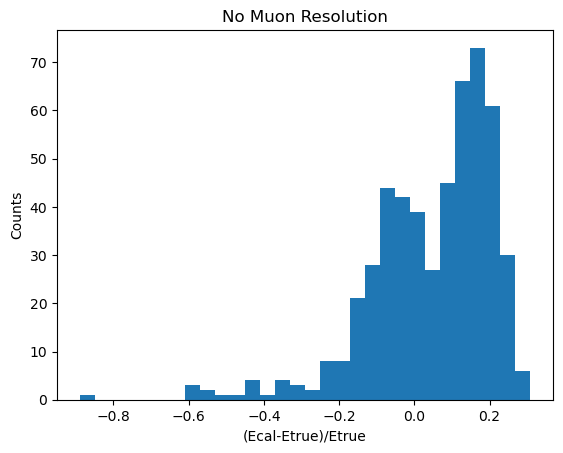

In [43]:
CeLehist3 = calibrator2('output_nt_Energy_dataNoMu.csv')
plt.title("No Muon Resolution")
plt.xlabel("(Ecal-Etrue)/Etrue")
plt.ylabel("Counts")
plt.hist(CeLehist3, bins = 30);
std_dev = np.std(CeLehist3)
print(np.mean(CeLehist3))
print("Total Detector resolution: " + str(std_dev))

Indeed it would seem like the muons were causing some issue. I only ran for 500 events, so there is some element of statistical uncertainty, but there still seems to be quite a skew to the right. I am going to investigate the datafiles and see if I spot anything. At the beginning it would appear that some of the particles aren't hitting the detector, I am going to increase the starting energy and see the difference. It obviously wont be the points on the right, if no energy is being deposited we would expect it on the left side of the graph - I just worry that it could be messing with my calibration

0.02919674485196833
Total Detector resolution: 0.15195190208560272


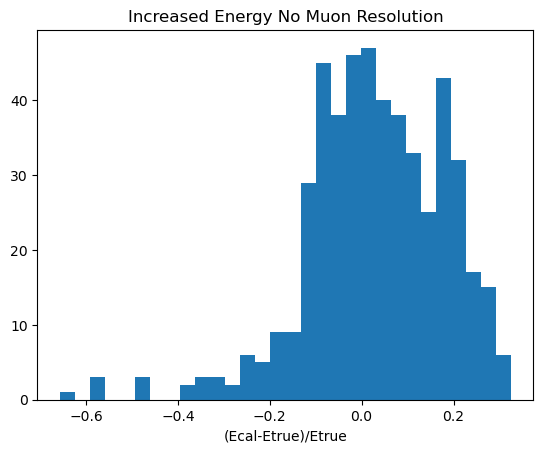

In [41]:
CeLehist4 = calibrator2('output_nt_Energy_dataNoMu2.csv')
plt.title("Increased Energy No Muon Resolution")
plt.xlabel("(Ecal-Etrue)/Etrue")
plt.ylabel("Counts")
plt.hist(CeLehist4, bins = 30);
std_dev = np.std(CeLehist4)
print(np.mean(CeLehist4))
print("Total Detector resolution: " + str(std_dev))

The above looks much more promising, as one final resolution test I will run the above setup for a few hundred events and see what I get

0.026923261552182415
Total Detector resolution: 0.1458543124024007


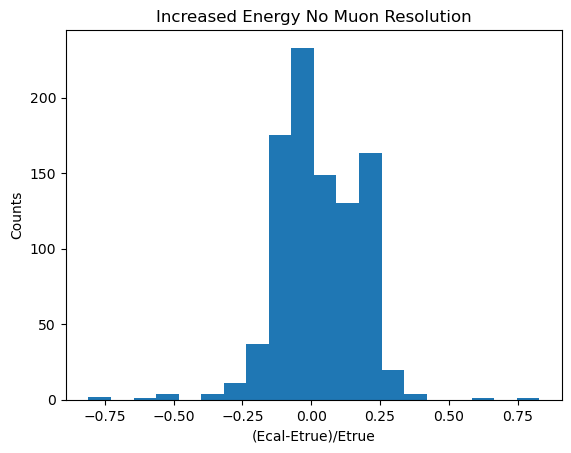

In [56]:
CeLehist5 = calibrator2('output_nt_Energy_dataNoMu3.csv')
plt.title("Increased Energy No Muon Resolution")
plt.xlabel("(Ecal-Etrue)/Etrue")
plt.ylabel("Counts")
plt.hist(CeLehist5, bins = 20);
std_dev = np.std(CeLehist5)
print(np.mean(CeLehist5))
print("Total Detector resolution: " + str(std_dev))

This looks good to me! Comparing the last two, I Imagine that if I were to do 10* the events this resolution would become better, but for now I am happy with this.

To summarise, this was achieved by altering the size of the detectors, the material combinations and then realising that the lack of a muon detector was causing other issues.

As a final task, I wish to make sure my NN can still train and understand this final setup.

In [57]:
file1 = 'output_nt_Energy_dataNoMu3.csv'
file2 = 'output_nt_Silicon1DataNoMu3.csv'
file3 = 'output_nt_Silicon2DataNoMu3.csv'


(659, 7) (659, 11) (74, 7) (74, 11)


In [59]:
#Just chose random node number, layer number, batchsize and epochs, seemed to work well
Model3 = my_model(7, 20, 1, 5)
#
batchSize = 16
N_epochs = 50
#Training as required - didn't implement early stopping as the difference made would be near negligible
History3 = Model3.fit(train_data1 ,train_target1 ,batch_size = batchSize , epochs = N_epochs , verbose =1 , validation_data=(test_data1 , test_target1 ))

Epoch 1/50
225/225 [==============================] - 2s 4ms/step - loss: 1.3349 - accuracy: 0.4968 - val_loss: 0.8759 - val_accuracy: 0.5990
Epoch 2/50
225/225 [==============================] - 1s 3ms/step - loss: 0.6845 - accuracy: 0.7425 - val_loss: 0.4528 - val_accuracy: 0.8822
Epoch 3/50
225/225 [==============================] - 1s 3ms/step - loss: 0.4583 - accuracy: 0.8335 - val_loss: 0.3257 - val_accuracy: 0.8947
Epoch 4/50
225/225 [==============================] - 1s 3ms/step - loss: 0.3744 - accuracy: 0.8644 - val_loss: 0.2679 - val_accuracy: 0.9148
Epoch 5/50
225/225 [==============================] - 1s 3ms/step - loss: 0.3168 - accuracy: 0.8912 - val_loss: 0.2252 - val_accuracy: 0.9198
Epoch 6/50
225/225 [==============================] - 1s 3ms/step - loss: 0.2872 - accuracy: 0.8987 - val_loss: 0.2041 - val_accuracy: 0.9323
Epoch 7/50
225/225 [==============================] - 1s 3ms/step - loss: 0.2680 - accuracy: 0.9063 - val_loss: 0.1862 - val_accuracy: 0.9323
Epoch 

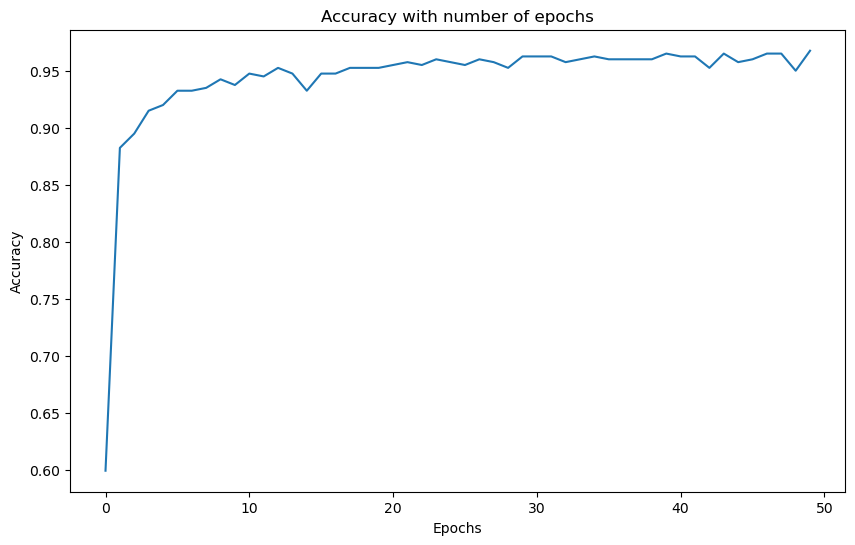

In [60]:
#Plotting my accuracy
plt.figure(figsize=(10,6))
plt.plot(History3.history['val_accuracy'])
plt.title('Accuracy with number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

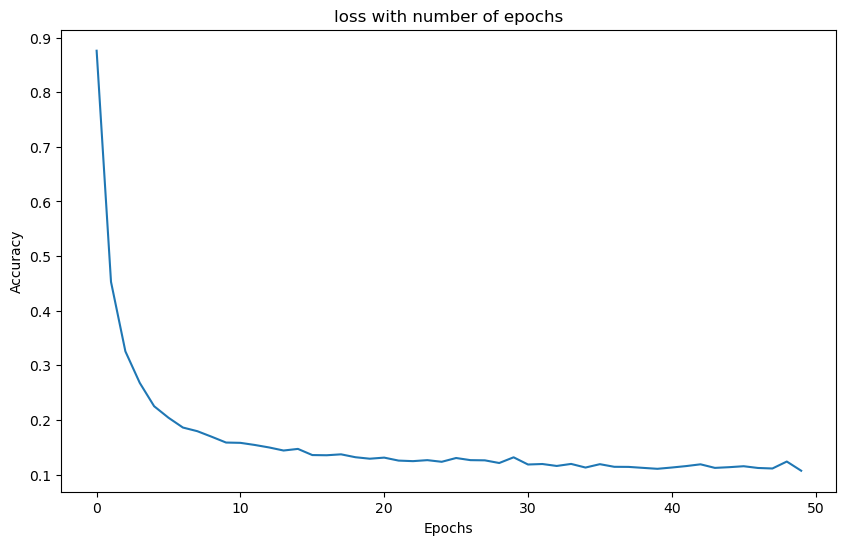

In [62]:
#Plotting my accuracy
plt.figure(figsize=(10,6))
plt.plot(History3.history['val_loss'])
plt.title('loss with number of epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

All good - therefore my detector can handle quite a few different particles and at a few orders of magnitude energy difference! See below for an image of my final detector

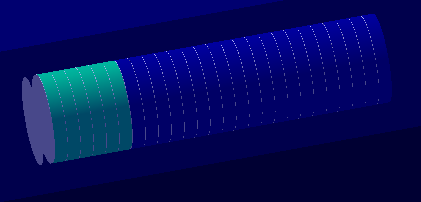

- Not very impressive to look at unfortunately